In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../..'))

# Autoreload changes in utils, etc.
%load_ext autoreload
%autoreload 2

from novelty.utils.metrics import plot_roc, plot_prc
from novelty.utils.metrics import get_summary_statistics
from novelty.utils.metrics import html_summary_table
from novelty.utils.metrics import barcode_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Training settings
BATCH_SIZE = 128
TEST_BATCH_SIZE = 1000
EPOCHS = 100
LR = 0.01
MOMENTUM = 0.5
NO_CUDA = False
SEED = 1

# MNIST mean and stdevs of training data by channel
CHANNEL_MEANS = (0.1307,)
CHANNEL_STDS = (0.3081,)

# Plot ROC and PR curves
PLOT_CHARTS = True

# ODIN parameters
TEMP = 1000.
NOISE_MAGNITUDE = 0.0012

## Create network architecture

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # return F.log_softmax(x, dim=1)
        return x

## Training and Testing functions

In [72]:
from novelty.utils import Progbar


def train(model, device, train_loader, optimizer, epoch):
    progbar = Progbar(target=len(train_loader.dataset))

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        progbar.add(len(data), [("loss", loss.item())])

In [73]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = F.log_softmax(model(data), dim=1)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Initialize model and load MNIST

In [74]:
from novelty.utils import DATA_DIR

torch.manual_seed(SEED)

use_cuda = not NO_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

In [75]:
from novelty.utils import DatasetSubset

INLIER_CLASSES = [0, 1, 2, 3, 4]
OUTLIER_CLASSES = [5, 6, 7, 8, 9]

mnist_train_inliers_dataset = DatasetSubset(datasets.MNIST(
    DATA_DIR, train=True, transform=transform, download=True), INLIER_CLASSES)

mnist_test_inliers_dataset = DatasetSubset(datasets.MNIST(
    DATA_DIR, transform=transform, download=True), INLIER_CLASSES)

mnist_test_outliers_dataset = DatasetSubset(datasets.MNIST(
    DATA_DIR, transform=transform, download=True), OUTLIER_CLASSES)

In [76]:
# Load training and test sets
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    mnist_train_inliers_dataset,
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    mnist_test_inliers_dataset,
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

# Create model instance
model = Net().to(device)

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

## Optimization loop

In [77]:
MODEL_PATH = './cnn_mnist_split_net.pth'

if os.path.exists(MODEL_PATH):
    # load previously trained model:
    model.load_state_dict(torch.load(MODEL_PATH))

else:
    # Training loop
    for epoch in range(1, EPOCHS + 1):
        print("Epoch:", epoch)
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

    # save the model 
    torch.save(model.state_dict(), MODEL_PATH)

## ODIN prediction functions

In [78]:
from torch.autograd import Variable


def predict(model, data, device):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_temp(model, data, device, temp=1000.):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs /= temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_novelty(model, data, device, temp=1000., noiseMagnitude=0.0012):
    model.eval()

    # Create a variable so we can get the gradients on the input
    inputs = Variable(data.to(device), requires_grad=True)

    # Get the predicted labels
    outputs = model(inputs)
    outputs = outputs / temp
    outputs = F.log_softmax(outputs, dim=1)

    # Calculate the perturbation to add to the input
    maxIndexTemp = torch.argmax(outputs, dim=1)
    labels = Variable(maxIndexTemp).to(device)
    loss = F.nll_loss(outputs, labels)
    loss.backward()

    # Normalizing the gradient to binary in {0, 1}
    gradient = torch.ge(inputs.grad.data, 0)
    gradient = (gradient.float() - 0.5) * 2

    # Normalize the gradient to the same space of image
    for channel, (mean, std) in enumerate(zip(CHANNEL_MEANS, CHANNEL_STDS)):
        gradient[0][channel] = (gradient[0][channel] - mean) / std

    # Add small perturbations to image
    # TODO, this is from the released code, but disagrees with paper I think
    tempInputs = torch.add(inputs.data, -noiseMagnitude, gradient)

    # Get new outputs after perturbations
    outputs = model(Variable(tempInputs))
    outputs = outputs / temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    outputs = F.softmax(outputs, dim=1)

    return outputs

## Evaluate method on outlier datasets

In [79]:
def get_max_model_outputs(data_loader, device):
    """Get the max softmax output from the model in a Python array.

    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.

    device: object
        The CUDA device handle.
    """
    result = []
    
    for data, target in data_loader:
        # Using regular model
        p = predict(model, data, device)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result


def get_max_odin_outputs(data_loader, device, temp=1000., noiseMagnitude=0.0012):
    """Convenience function to get the max softmax values from the ODIN model in a Python array.
    
    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.
        
    device: object
        The CUDA device handle.
        
    temp: float, optional (default=1000.)
        The temp the model should use to do temperature scaling on the softmax outputs.
        
    noiseMagnitude: float, optional (default=0.0012)
        The epsilon value used to scale the input images according to the ODIN paper.
    """
    result = []
    
    for data, target in data_loader:
        # Using ODIN model
        p = predict_novelty(model, data, device, temp=temp, noiseMagnitude=noiseMagnitude)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result

In [80]:
# Build results table
results = {
    "CNN": {
        "inlier_name": "MNIST (0-4)",
        "outliers": {}
    },
    "CNN_ODIN": {
        "inlier_name": "MNIST (0-4)",
        "outliers": {}
    }
}

### Predict on MNIST Inliers

In [81]:
num_inliers = len(test_loader.dataset)

# Get predictions on in-distribution images
mnist_model_maximums = get_max_model_outputs(test_loader, device)
mnist_odin_maximums = get_max_odin_outputs(test_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

### Predict on MNIST Outliers

In [82]:
# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

outlier_loader = torch.utils.data.DataLoader(
    mnist_test_outliers_dataset,
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

num_outliers = len(outlier_loader.dataset)

# Get predictions on in-distribution images
outlier_model_maximums = get_max_model_outputs(outlier_loader, device)
outlier_odin_maximums = get_max_odin_outputs(outlier_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

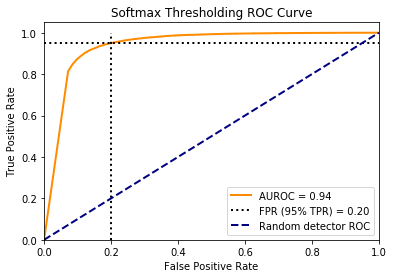

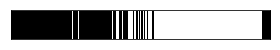

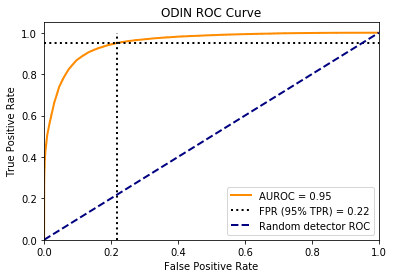

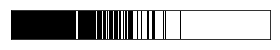

In [91]:
labels = [1] * num_inliers + [0] * num_outliers
predictions = mnist_model_maximums + outlier_model_maximums
predictions_odin = mnist_odin_maximums + outlier_odin_maximums

results["CNN"]["outliers"]["5-9 MNIST"] = get_summary_statistics(predictions, labels)
results["CNN_ODIN"]["outliers"]["5-9 MNIST"] = get_summary_statistics(predictions_odin, labels)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    barcode_plot(predictions, labels)

    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")    
    barcode_plot(predictions_odin, labels)

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve (In)")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve (In)")
    
#     plot_prc([-a for a in predictions], [1 - a for a in labels], title="Softmax Thresholding PRC Curve (Out)")
#     plot_prc([-a for a in predictions_odin], [1 - a for a in labels], title="ODIN PRC Curve (Out)")

# Show Results Table

In [84]:
from IPython.display import HTML, display

table = html_summary_table(results)
display(HTML(table))

Model,Out-of-distribution dataset,FPR (95% TPR),Detection Error,AUROC,AUPR In,AUPR Out
CNN (MNIST (0-4)),5-9 MNIST,20.1,12.5,93.8,94.1,95.0
CNN_ODIN (MNIST (0-4)),5-9 MNIST,21.6,13.3,95.3,95.6,95.1
